<a href="https://colab.research.google.com/github/yyduyuxuan/Machine-Learning-for-Data-Driven-Inventory-Replenishment-Evidence-from-the-M5-Retail-Dataset/blob/main/PREDICT_Store_Dept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

from math import ceil

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [ ]:
def get_memory_usage():
    return np.round(psutil.Process(os.getpid()).memory_info()[0]/2.**30, 2)

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [ ]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = '/content/drive/MyDrive/Colab Notebooks/Supervised Project/sales_long_val_5y.pkl'
sales_long_val = pd.read_pickle(file_path)

print(sales_long_val.shape)
sales_long_val.head()

Mounted at /content/drive
(45974682, 119)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,enc_std_store_id_dept_id,enc_mean_item_id,enc_std_item_id,enc_mean_item_id_state_id,enc_std_item_id_state_id,enc_mean_item_id_store_id,enc_std_item_id_store_id,ROP_L3,ROP_L7,ROP_L14
0,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,3,2011-01-29,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,NaN,NaN,NaN
1,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2,0,2011-01-30,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,NaN,NaN,NaN
2,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,2011-01-31,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,5.0,NaN,NaN
3,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,1,2011-02-01,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,7.0,NaN,NaN
4,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,5,4,2011-02-02,11101,...,3.357422,0.719238,1.333008,0.968262,1.662109,0.833984,1.375,6.0,NaN,NaN


In [ ]:
sales_long_pre_predict = pd.read_pickle(("/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/sales_long_pre_predict_1year.pkl"))

In [ ]:
sales_long_pre_predict.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,enc_std_store_id_dept_id,enc_mean_item_id,enc_std_item_id,enc_mean_item_id_state_id,enc_std_item_id_state_id,enc_mean_item_id_store_id,enc_std_item_id_store_id,ROP_L3,ROP_L7,ROP_L14
1461,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1462,1,2015-01-29,11452,...,3.322266,0.674805,1.317383,0.931152,1.671875,0.830566,1.318359,4.0,4.0,9.0
1462,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1463,0,2015-01-30,11452,...,3.324219,0.674316,1.317383,0.930664,1.670898,0.830566,1.318359,3.0,3.0,8.0
1463,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1464,3,2015-01-31,11501,...,3.324219,0.674316,1.316406,0.930176,1.670898,0.830078,1.317383,3.0,3.0,12.0
1464,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1465,0,2015-02-01,11501,...,3.324219,0.674805,1.317383,0.931152,1.670898,0.831543,1.318359,0.0,0.0,11.0
1465,FOODS_1_001_CA_1_validation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1466,0,2015-02-02,11501,...,3.324219,0.674316,1.316406,0.930664,1.670898,0.831055,1.318359,0.0,2.0,12.0


In [ ]:
print(sales_long_pre_predict.columns.tolist())
print(f"Total columns: {len(sales_long_pre_predict.columns)}")

['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'release', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'lag_1_minus_7', 'lag_7_minus_14', 'lag_14_minus_28', 'ADI_30', 'CV2_30', 'ADI_60', 'CV2_60', 'ADI_90', 'CV2_90', 'day_of_year', 'sin_doy', 'cos_doy', 'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'is_weekend', 'price_lag_7', 'price_change_flag', 'is_discontinued', 'price_max', 'price_min', 'price_mean', 'price_std', 'price_norm', 'price_nunique', 'item_nunique', 'price_momentum', 'price_momentum_m', 'price_momentum_y', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41', 'lag_42', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30', 'rolling_std_30', 'rolling_mean_60', 'rolling_std_60', '

In [ ]:
# Group
group_key = ['store_id', 'dept_id']

group_names = sales_long_pre_predict[group_key].drop_duplicates().values.tolist()
print(f"Total groups: {len(group_names)}")

Total groups: 70


# ML Predict

In [ ]:
from sklearn.preprocessing import LabelEncoder

for col in ['weekday']:
    if sales_long_pre_predict[col].dtype == 'object':
        le = LabelEncoder()
        sales_long_pre_predict[col] = le.fit_transform(sales_long_pre_predict[col])


In [ ]:
!pip install tqdm

In [ ]:
label_col = 'ROP_L3'
group_key = ['store_id', 'dept_id']
remove_feature=[
        # ID
        'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
        'd', 'date', 'wm_yr_wk','sales',

        # ROP label
        'ROP_L3', 'ROP_L7', 'ROP_L14',

        # mean encoding, avoid target leakage
        'enc_mean_store_id', 'enc_std_store_id',
        'enc_mean_dept_id', 'enc_std_dept_id',
        'enc_mean_store_id_cat_id', 'enc_std_store_id_cat_id',
        'enc_mean_state_id_dept_id', 'enc_std_state_id_dept_id',
        'enc_mean_store_id_dept_id', 'enc_std_store_id_dept_id',
        'enc_mean_item_id_store_id', 'enc_std_item_id_store_id']

In [ ]:
import os, pickle
import pandas as pd
from tqdm import tqdm

model_dir = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/models_store_dept_3y_retrain/"
out_path  = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/preds_store_dept_1ytest.pkl"


pred_source = sales_long_pre_predict.copy()

pred_parts, missing = [], []

for gvals, gdf in tqdm(list(pred_source.groupby(group_key)), desc="Predict per group", unit="group"):
    group_id = "_".join(map(str, gvals))
    mdl_path = os.path.join(model_dir, f"model_{group_id}.bin")
    if not os.path.exists(mdl_path):
        missing.append(group_id)
        continue

    with open(mdl_path, "rb") as f:
        model = pickle.load(f)

    drop_cols = [c for c in (remove_feature + [label_col]) if c in gdf.columns]
    Xp = gdf.drop(columns=drop_cols, errors='ignore')

    # Align columns with feature names from training
    train_feats = list(model.feature_name_)
    Xp = Xp.reindex(columns=train_feats, fill_value=0)

    preds = model.predict(Xp)

    keep_cols = ['state_id','dept_id','item_id','store_id','d','date']
    keep_cols = [c for c in keep_cols if c in gdf.columns]
    out = gdf[keep_cols].copy()
    out['pred'] = preds
    pred_parts.append(out)

pred_df = pd.concat(pred_parts, ignore_index=True) if pred_parts else pd.DataFrame()
print(f"[DONE] predicted rows = {len(pred_df)} / input rows = {len(pred_source)}")
if missing:
    print(f"[WARN] missing {len(missing)} group models, e.g. {missing[:5]}")

if not pred_df.empty:
    pred_df.to_pickle(out_path)
    print(f"[SAVE] {out_path}")

Predict per group: 100%|██████████| 70/70 [19:00<00:00, 16.29s/group]


[DONE] predicted rows = 10968097 / input rows = 10968097
[SAVE] /content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/preds_store_dept_1ytest.pkl


In [ ]:
pred_df.head()

,state_id,dept_id,item_id,store_id,d,date,pred
0,CA,FOODS_1,FOODS_1_001,CA_1,1462,2015-01-29,3.419091
1,CA,FOODS_1,FOODS_1_001,CA_1,1463,2015-01-30,3.525100
2,CA,FOODS_1,FOODS_1_001,CA_1,1464,2015-01-31,3.232425
3,CA,FOODS_1,FOODS_1_001,CA_1,1465,2015-02-01,2.830319
4,CA,FOODS_1,FOODS_1_001,CA_1,1466,2015-02-02,2.903663


# Merge the table

In [ ]:
import numpy as np
import pandas as pd

L = 3
keys = ['state_id','dept_id','item_id','store_id']

pred_df = pred_df.copy()
ref_df  = sales_long_pre_predict.copy()
if 'date' in pred_df.columns:
    pred_df = pred_df.drop(columns=['date'])
for k in keys:
    pred_df[k] = pred_df[k].astype(str).str.strip()
    ref_df[k]  = ref_df[k].astype(str).str.strip()

ref_df = ref_df.sort_values(keys + ['d'])

ref_df['true'] = (
    ref_df.groupby(keys)['sales']
          .transform(lambda s: s.shift(-(L-1)).rolling(L).sum())
)

ref_keep = (ref_df[ref_df['d'].isin(pred_df['d'].unique())]
            [['d','date'] + keys + ['true']]
            .dropna(subset=['true'])
            .drop_duplicates(subset=['d']+keys))

eval_df = (pred_df.merge(ref_keep, on=['d']+keys, how='inner', validate='one_to_one')
                 [['d','date'] + keys + ['true','pred']]
                 .sort_values(keys+['d'])
                 .reset_index(drop=True))


eval_df.head()

,d,date,state_id,dept_id,item_id,store_id,true,pred
0,1464,2015-01-31,CA,FOODS_1,FOODS_1_001,CA_1,3.0,3.232425
1,1465,2015-02-01,CA,FOODS_1,FOODS_1_001,CA_1,0.0,2.830319
2,1466,2015-02-02,CA,FOODS_1,FOODS_1_001,CA_1,0.0,2.903663
3,1467,2015-02-03,CA,FOODS_1,FOODS_1_001,CA_1,0.0,2.935292
4,1468,2015-02-04,CA,FOODS_1,FOODS_1_001,CA_1,0.0,2.821949


In [ ]:
eval_df.to_pickle("/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/eval_df_store_dept_pred_1y.pkl")

# Evaluation with errors

In [ ]:
eval_df = eval_df.dropna(subset=['true', 'pred']).copy()

In [ ]:
import numpy as np
import pandas as pd

def ensure_dnum_col(df):
    if 'd_num' in df.columns:
        return df['d_num']
    if np.issubdtype(df['d'].dtype, np.number):
        return df['d'].astype(int)
    return pd.to_numeric(df['d'].astype(str).str.extract(r'(\d+)', expand=False), errors='coerce')

def build_train_rop_from_sales(full_sales: pd.DataFrame, lt: int, end_day: int) -> pd.DataFrame:
    req = {'item_id','store_id','d','sales'}
    miss = req - set(full_sales.columns)
    if miss: raise ValueError(f"Missing cols: {miss}")

    df = full_sales[['item_id','store_id','d','sales']].copy()
    df['d_num'] = ensure_dnum_col(df)

    df = df.sort_values(['item_id','store_id','d_num'])
    df['ROP_train'] = (
        df.groupby(['item_id','store_id'])['sales']
          .transform(lambda x: x.shift(-(lt-1)).rolling(lt).sum())
    )

    last_t = int(end_day) - (lt - 1)         # keep ROPs that end ≤ end_day
    df = df[df['d_num'].notna() & (df['d_num'] <= last_t)]
    df = df.dropna(subset=['ROP_train'])

    return df[['item_id','store_id','d_num','ROP_train']]

def evaluate_item_store(eval_df: pd.DataFrame,
                        full_history: pd.DataFrame,      # <-- full history table
                        keys: list[tuple[str,str]],
                        lt: int = 3,
                        train_end: int = None) -> pd.DataFrame:

    if train_end is None:
        raise ValueError("train_end must be the last training day (e.g., from cv_meta['train_end_d']).")

    train_rop = build_train_rop_from_sales(full_history, lt=lt, end_day=train_end)

    rows = []
    for item_id, store_id in keys:
        g = eval_df[(eval_df['item_id']==item_id) & (eval_df['store_id']==store_id)].sort_values('d')
        if g.empty:
            rows.append({'SeriesName': f'{item_id}_{store_id}', 'RMSSE': np.nan, 'note': 'no eval rows'})
            continue

        y_true = g['true'].astype(float).to_numpy()
        y_pred = g['pred'].astype(float).to_numpy()

        tr = train_rop[(train_rop['item_id']==item_id) & (train_rop['store_id']==store_id)]['ROP_train'].to_numpy()
        if tr.size < 2:
            rows.append({'SeriesName': f'{item_id}_{store_id}', 'RMSSE': np.nan, 'note': 'no/short train ROP'})
            continue

        rmse = float(np.sqrt(np.mean((y_pred - y_true)**2)))
        me   = float(np.mean(y_pred - y_true))
        m    = float(np.mean(y_true)) if np.isfinite(np.mean(y_true)) else np.nan
        nrmse= rmse / (m + 1e-8)
        nme  = me   / (m + 1e-8)

        denom = float(np.mean((tr[1:] - tr[:-1])**2))
        rmsse = rmse / np.sqrt(denom) if denom > 0 else np.nan
        note  = None if denom > 0 else 'train ROP constant ⇒ denom=0'

        rows.append({
            'SeriesName': f'{item_id}_{store_id}',
            'RMSE': rmse, 'Norm_RMSE': nrmse,
            'ME': me, 'Norm_ME': nme,
            'RMSSE': rmsse, 'note': note
        })

    return pd.DataFrame(rows)

In [ ]:
results_dir = "/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/results_store_dept_3y_retrain/"

In [ ]:
target_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/target_uids.csv")

In [ ]:
def uid_to_item_store(uid: str):
    parts = str(uid).split('_')
    item_id  = '_'.join(parts[:-2])
    store_id = parts[-2] + '_' + parts[-1]
    return item_id, store_id

keys_from_target = list({
    uid_to_item_store(uid)
    for uid in target_df['unique_id'].dropna().astype(str)
})

In [ ]:
# Use full history and the SAME training end day as the model
with open(os.path.join(results_dir, "cv_meta.pkl"), "rb") as f:
    meta = pickle.load(f)

df_eval_20 = evaluate_item_store(
    eval_df,
    sales_long_val,         # full history table
    keys_from_target,
    lt=3,
    train_end=meta["train_end_d"]
)
display(df_eval_20.sort_values('SeriesName'))

,SeriesName,RMSE,Norm_RMSE,ME,Norm_ME,RMSSE,note
116,FOODS_1_145_CA_1,3.527135,0.638871,-0.005885,-0.001066,1.282771,None
12,FOODS_1_145_CA_3,3.335569,0.626619,-0.126448,-0.023754,0.989449,None
99,FOODS_1_145_CA_4,2.162876,0.716964,-0.251346,-0.083318,1.218240,None
87,FOODS_1_145_TX_1,2.320355,0.683353,-0.044838,-0.013205,0.964277,None
155,FOODS_1_145_TX_2,2.554038,0.704224,0.199775,0.055084,0.827885,None
...,...,...,...,...,...,...,...
16,HOUSEHOLD_2_371_TX_1,1.834862,1.514289,-0.255500,-0.210861,2.258432,None
76,HOUSEHOLD_2_371_TX_2,1.571114,1.504080,0.183450,0.175622,0.871153,None
115,HOUSEHOLD_2_371_TX_3,3.727648,0.880412,-0.159736,-0.037727,1.382839,None
84,HOUSEHOLD_2_371_WI_1,3.062714,0.677458,-0.133633,-0.029559,1.319310,None


In [ ]:
df_eval_20.to_csv("/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/store_dept_df_eval_159.csv")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_true_vs_pred(df_forecast, true_col='true', pred_col='pred',
                      n_points=28, title='Prediction vs True'):
    df_plot = df_forecast.sort_values(by='date').copy()

    if n_points:
        df_plot = df_plot[-n_points:]

    y_true = df_plot[true_col]
    y_pred = df_plot[pred_col]
    x_vals = df_plot['date']  # Change to date

    plt.figure(figsize=(18, 6))
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("ROP")

    sns.lineplot(x=x_vals, y=y_true, label='True', color='black', linewidth=2.5)
    sns.lineplot(x=x_vals, y=y_pred, label='Prediction', color='blue', linewidth=2.5)

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

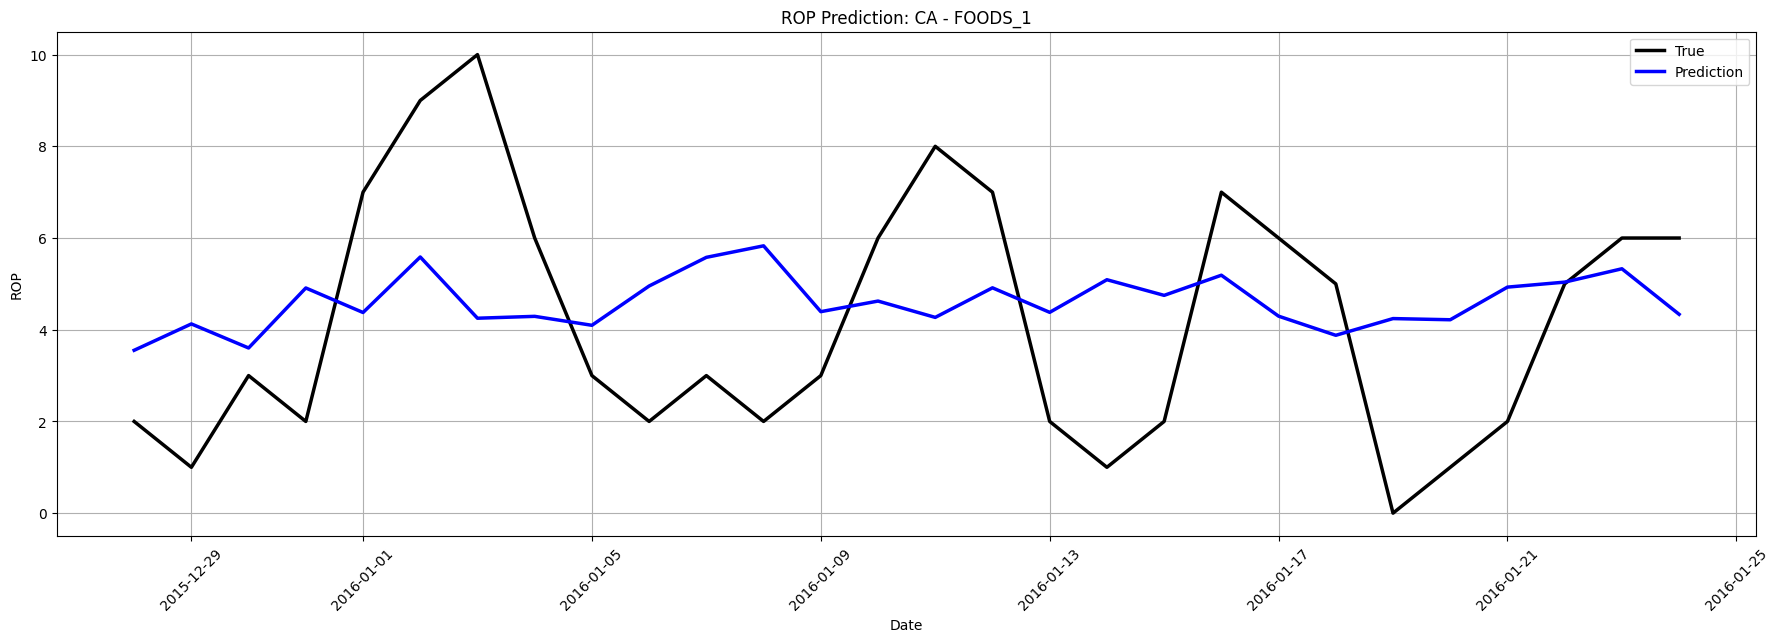

In [ ]:
sample_group_df = eval_df[
    (eval_df['state_id'] == 'CA') &
    (eval_df['dept_id'] == 'FOODS_1') &
    (eval_df['item_id'] == 'FOODS_1_145') &
    (eval_df['store_id'] == 'CA_1')
]

plot_true_vs_pred(sample_group_df, true_col='true', pred_col='pred',
                  n_points=28, title='ROP Prediction: CA - FOODS_1')